In [1]:
# Importing Dependencies
import tensorflow as tf
from google.colab import drive
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator # To generate data
from tensorflow.keras.applications import MobileNetV2  ## Pre - Trained Model
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix, classification_report
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

In [4]:


training_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training'
validation_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/2_Validation'
testing_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/3_Testing'

def resize_images(image):
    resized_image = resize(image.squeeze(), (128, 128))
    return np.expand_dims(resized_image, axis=-1)

def rgb_to_gray(image):
    return rgb2gray(image)

np.random.seed(14)
tf.random.set_seed(14)

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=lambda x: resize(x.squeeze(), (128, 128)),
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Fitting the ImageDataGenerator onto the Training data
datagen.fit(np.zeros((1, 128, 128, 3)))

# Defining Training and Validation sets
train_generator = datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    # batch_size=1154,
    batch_size=2000,
    class_mode='binary',
)

validation_generator = datagen.flow_from_directory(
    validation_path,
    target_size=(128, 128),
    batch_size=208,
    class_mode='binary',
)

Found 1154 images belonging to 2 classes.
Found 208 images belonging to 2 classes.


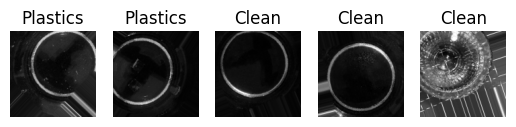

In [5]:

batch = next(train_generator)

images, labels = batch

# Updating labels for better readability
updated_labels = ["Clean" if label == 0 else "Plastics" for label in labels]

# Displaying the first few images along with their labels
num_images_to_display = 5
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(images[i][:, :, 0], cmap='gray')
    plt.title(f"{updated_labels[i]}")
    plt.axis('off')

plt.show()

In [6]:
# Double checking the shape of the output from the resizing
# Even though images are Greyscale, we want to make sure that the color channels are 3, so they are compatable with MobileNetV2.
sample_batch = next(train_generator)
sample_image = sample_batch[0][0]
print("Shape after resize_images:", sample_image.shape)

Shape after resize_images: (128, 128, 3)


In [7]:
# Building the Image Classification Model, using Convolutional Neural Network, via MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freezing the convolutional base
base_model.trainable = False

# Modeling with classification head on top of MobileNetV2
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='elu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='leaky_relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
# Training the Model
epochs = 50

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator)

# Generating Evaluation from the Training & Validation Sets
train_loss, train_accuracy = model.evaluate(train_generator)
valid_loss, valid_accuracy = model.evaluate(validation_generator)

# Displaying accuracy & loss.
print(f'Training Accuracy: {train_accuracy}')
print(f'Training Loss: {train_loss}')
print(f'----------------------------------------')
print(f'Validation Accuracy: {valid_accuracy}')
print(f'Validation Loss: {valid_loss}')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 229s 229s/step - accuracy: 0.4931 - loss: 1.0177 - val_accuracy: 0.5000 - val_loss: 1.2438
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.5000 - loss: 1.4439 - val_accuracy: 0.5000 - val_loss: 0.8068
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.5095 - loss: 0.9647 - val_accuracy: 0.5337 - val_loss: 0.6843
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.5373 - loss: 0.7466 - val_accuracy: 0.5000 - val_loss: 0.7702
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.5260 - loss: 0.7914 - val_accuracy: 0.5048 - val_loss: 0.7843
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.5433 - loss: 0.7922 - val_accuracy: 0.5192 - val_loss: 0.7153
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.5537 - loss: 0.7407 - val_accuracy: 0.5769 - val_loss: 0.6693
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.5754 - loss: 0.6954 - val_accuracy: 0.5385 - val_loss: 0.6703
Epoch 9/5

## Testing The Model Performence on Test data

In [9]:
# Evaluating the model on the testing set
testing_generator = datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=200,
    class_mode='binary',
    shuffle=True,

)

# Generating Evaluation from the testing set
test_loss, test_accuracy = model.evaluate(testing_generator)


print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Loss: {test_loss}')

Found 200 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.6600 - loss: 0.6187
Testing Accuracy: 0.6600000262260437
Testing Loss: 0.6187292337417603


In [10]:
# Generating predictions on the testing set
predictions = model.predict(testing_generator)

# Converting predictions to binary values (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Getting true labels from the generator
true_labels = testing_generator.classes

# Displaying confusion matrix
conf_matrix = confusion_matrix(true_labels, binary_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Displaying classification report
classification_rep = classification_report(true_labels, binary_predictions)
print("Classification Report:")
print(classification_rep)

# Displaying accuracy & loss
print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Loss: {test_loss}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Confusion Matrix:
[[33 67]
 [35 65]]
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.33      0.39       100
           1       0.49      0.65      0.56       100

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.48       200
weighted avg       0.49      0.49      0.48       200

Testing Accuracy: 0.6600000262260437
Testing Loss: 0.6187292337417603


In [11]:
# Getting the predicted labels from the results
# predicted_labels = (binary_predictions > 0.5).astype(int)

# Comparing the True Labels to the Predicted Labels
print("True Labels:")
print(true_labels)
print(f'---------------------------------------------------------')
print("Testing Predicted Labels:")
print(binary_predictions.flatten())

True Labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
---------------------------------------------------------
Testing Predicted Labels:
[1 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 0
 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1
 0 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0
 1 1 1 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1
 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0]


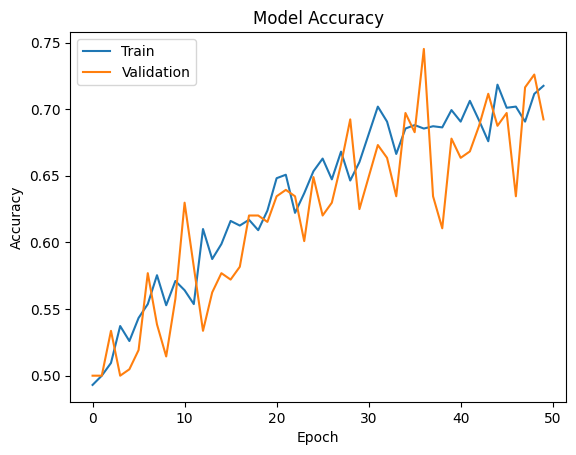

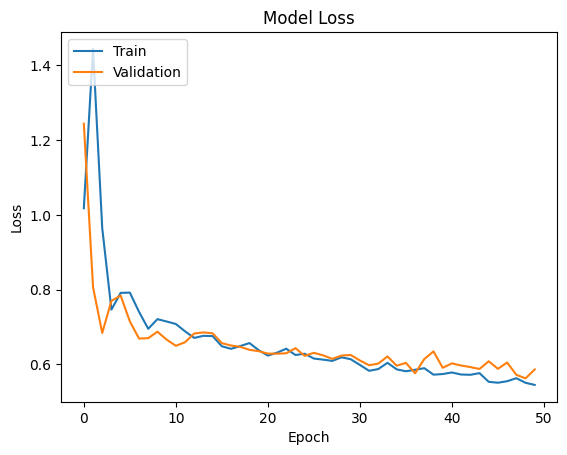

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
test_image = images[0]
print(test_image.shape)



(128, 128, 3)


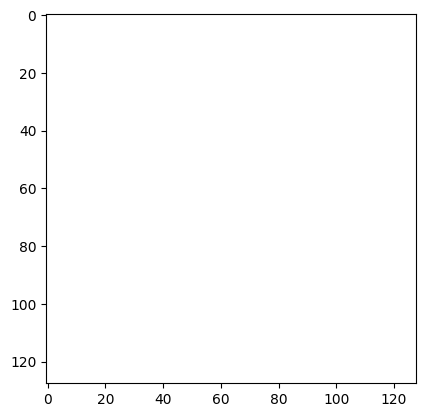

In [19]:
plt.imshow(test_image[0:])
plt.show()

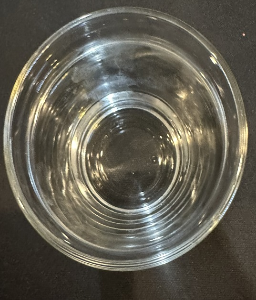

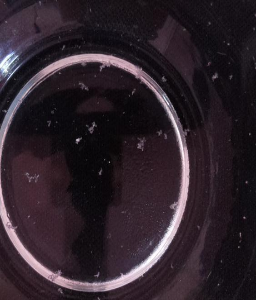

In [51]:

from google.colab.patches import cv2_imshow

# Replace with the path to your image
test_clean_image_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training/1_Clean_Water/x-Clean-00023.jpg'
test_microPla_image_path = '/content/drive/MyDrive/Mri_project_code/micro_plastic_img_data_set/MICRO_FOLDER/1_Training/2_Microplastics/10_jpg.rf.ecfa6fcdfec86c013936528ac959e40d.jpg'

# Load the image using OpenCV
clean_image = cv2.imread(test_clean_image_path)
clean_image = cv2.resize(clean_image,(256,300))
microPla_image = cv2.imread(test_microPla_image_path)
microPla_image = cv2.resize(microPla_image,(256,300))

cv2_imshow(clean_image)
cv2_imshow(microPla_image)

In [52]:

clean_image = resize(clean_image, (128, 128))
clean_image = clean_image.astype('float32') / 255.0
clean_image = np.expand_dims(clean_image, axis=0)

microPla_image = resize(microPla_image, (128, 128))
microPla_image = microPla_image.astype('float32') / 255.0
microPla_image = np.expand_dims(microPla_image, axis=0)



# Make prediction
prediction = model.predict(clean_image)
# prediction = model.predict(microPla_image)

# Print the prediction
if prediction > 0.5:
    print("Prediction: Plastics")
else:
    print("Prediction: Clean")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction: Clean


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction: Clean


# To increase the accuracy we apply some steps:
##1. Check the more activation functions
## 2. make changes in the Dropout
##3.  also can increase the Deep layers
##4.  Optimizers is adam (not) change

## Activation Elu

In [53]:

print(f"Training model with activation: elu ")

model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='elu'),
        Dropout(0.2),
        Dense(128, activation='elu'),
        Dropout(0.4),
        Dense(64, activation='elu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(train_generator, epochs=15, validation_data=validation_generator)

# Pulling the results
elu = history.history['val_accuracy']
print(elu)
# Plotting the results
plt.figure(figsize=(10, 6))

Training model with activation: elu 
Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step - accuracy: 0.5095 - loss: 0.9013 - val_accuracy: 0.5000 - val_loss: 0.9264
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.5217 - loss: 0.9080 - val_accuracy: 0.5240 - val_loss: 0.6931
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.5234 - loss: 0.7892 - val_accuracy: 0.5385 - val_loss: 0.6803
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.5113 - loss: 0.7828 - val_accuracy: 0.4904 - val_loss: 0.7012
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.5295 - loss: 0.7640 - val_accuracy: 0.5577 - val_loss: 0.6769
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.5433 - loss: 0.7220 - val_accuracy: 0.6154 - val_loss: 0.6772
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.5208 - loss: 0.7360 - val_accuracy: 0.5577 - val_loss: 0.6829
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.5641 - loss: 0.7197 - val

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

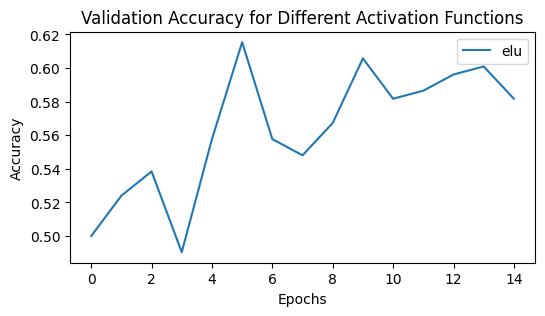

In [55]:
# Plot the results
plt.figure(figsize=(6, 3))
plt.plot(elu, label='elu')

plt.title('Validation Accuracy for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Activation relu

In [1]:

print(f"Training model with activation: relu ")

model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='tanh'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(train_generator, epochs=15, validation_data=validation_generator)

# Pulling the results
relu = history.history['val_accuracy']
print(relu)
# Plotting the results
plt.figure(figsize=(10, 6))

Training model with activation: elu 


NameError: name 'Sequential' is not defined

In [ ]:
# Plot the results
plt.figure(figsize=(6, 3))
plt.plot(relu, label='relu')

plt.title('Validation Accuracy for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Changes in activation function by using for loops

In [ ]:
# Testing alternative activation functions to find best candidates

# Creating activation list
activation_functions = ['leaky_relu', 'elu', 'tanh', 'selu', 'sigmoid', 'relu']

# Creating a dictionary to hold the activation function accuracy results
results = {}

# For-Looping the activation functions through the model
for activation in activation_functions:
    print(f"Training model with activation: {activation}")

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation=activation),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Training the model
    history = model.fit(train_generator, epochs=15, validation_data=validation_generator)

    # Pulling the results
    results[activation] = history.history['val_accuracy']

# Plotting the results
plt.figure(figsize=(10, 6))

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
for activation, accuracy in results.items():
    plt.plot(accuracy, label=activation)

plt.title('Validation Accuracy for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()